In [1]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 5.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [2]:
from sqlalchemy import create_engine
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import seaborn as sns
import warnings
from tensorflow.keras.utils import plot_model
warnings.filterwarnings('ignore')
from datetime import timedelta, date, datetime
import time
import matplotlib.ticker as tkr
from scipy import stats
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
from sklearn.preprocessing import MinMaxScaler
matplotlib.rcParams['text.color'] = 'k'
from pylab import rcParams
from statsmodels.tsa.seasonal import STL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, LSTM
from tensorflow.keras import optimizers

%matplotlib inline

In [3]:
from google.colab import files
import io
uploaded = files.upload()

Saving Global DataBase2 daily.csv to Global DataBase2 daily.csv
Saving Global DataBase3.csv to Global DataBase3.csv


In [4]:
df=pd.read_csv(io.BytesIO(uploaded['Global DataBase2 daily.csv']), index_col='datetime_per_day', parse_dates=True, dayfirst = True)

df2=pd.read_csv(io.BytesIO(uploaded['Global DataBase3.csv']), index_col='datetime', parse_dates=True, dayfirst =True)

df = df.loc['2017-01-01':'2020-12-31']
df2 = df2.loc['2017-01-01':'2020-12-31']

columns = ['Price - PT [€/MWh]','Price - ES [€/MWh]','Actual Consumption (MWh)','Biomass AA','Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC','Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA','Wind Onshore AA']
for column in columns : 
    df[column] = df2[column].resample("D").mean()

columns = ['Electricity Consumption (MWh)']
for column in columns : 
    df[column] = df2[column].resample("D").sum()
    
df = df.sort_index()


#Handeling global outliers
GlobalOutliers =  []
for i in range(0):
    GlobalOutliers.append(df.idxmax()['Price - PT [€/MWh]'])
    df.at[df.idxmax()['Price - PT [€/MWh]'], 'Price - PT [€/MWh]'] = np.nan

#Replacing them with the mean of that day
for d in GlobalOutliers:
    sdt = datetime.combine(d, datetime.min.time())
    edt = sdt + timedelta(hours=24)
    df.at[d, 'Price - PT [€/MWh]'] = df[sdt:edt]['Price - PT [€/MWh]'].mean()
    
#Handling negative values 
negativeIndex = df.index[df['Price - PT [€/MWh]'] < 0]
for index in (negativeIndex):
    df.at[index, 'Price - PT [€/MWh]']= df.at[index - timedelta(hours=1), 'Price - PT [€/MWh]']
    
df = df.dropna()

In [5]:
df = df.reset_index(level=0)

In [6]:
df["Date Time"] = pd.to_datetime(df['datetime_per_day'])

In [7]:
df["Day"] = df["Date Time"].dt.day
df["Month"] = df["Date Time"].dt.month
df["Year"] = df["Date Time"].dt.year
df["Hour"] = df["Date Time"].dt.hour
df["Minute"] = df["Date Time"].dt.minute
df["Demand"] = pd.to_numeric(df['Price - PT [€/MWh]'], errors = 'coerce')

In [8]:
print(df.columns)

Index(['datetime_per_day', 'Price - PT [€/MWh]', 'Price - ES [€/MWh]',
       'Actual Consumption (MWh)', 'Biomass AA', 'Fossil Gas AA',
       'Fossil Hard Coal AC', 'Hydro Pumped Storage AA',
       'Hydro Pumped Storage AC', 'Hydro Run-of-river and poundage AA',
       'Hydro Water Reservoir AA', 'Other AA', 'Solar AA', 'Wind Onshore AA',
       'Electricity Consumption (MWh)', 'Date Time', 'Day', 'Month', 'Year',
       'Hour', 'Minute', 'Demand'],
      dtype='object')


In [9]:
columns = ['datetime_per_day','Date Time', 'Price - PT [€/MWh]', 'Price - ES [€/MWh]','Actual Consumption (MWh)', 'Biomass AA', 'Fossil Gas AA','Fossil Hard Coal AC', 'Hydro Pumped Storage AA','Hydro Pumped Storage AC', 'Hydro Run-of-river and poundage AA','Hydro Water Reservoir AA', 'Other AA', 'Solar AA', 'Wind Onshore AA','Electricity Consumption (MWh)']
for column in columns :
  df.drop([column],  axis=1, inplace=True )

df

,Day,Month,Year,Hour,Minute,Demand
0,1,1,2017,0,0,51.42
1,2,1,2017,0,0,58.88
2,3,1,2017,0,0,65.25
3,4,1,2017,0,0,66.70
4,5,1,2017,0,0,66.86
...,...,...,...,...,...,...
1449,27,12,2020,0,0,29.10
1450,28,12,2020,0,0,19.62
1451,29,12,2020,0,0,38.26
1452,30,12,2020,0,0,48.91


In [10]:
X= []
y= []

In [11]:
for i in range(0, df.shape[0]-20):
    X.append(df.iloc[i:i+20,5])
    y.append(df.iloc[i+20,5])
    
X, y = np.array(X), np.array(y)
y = np.reshape(y, (len(y), 1))

In [12]:
pd.DataFrame(X).to_csv('appended_Demand_d.csv')
pd.DataFrame(y).to_csv('appended_Demand_1_d.csv')

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))

X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [14]:
#split
size = int(len(df)*0.8)
           
X_train, X_test = X[:size], X[size:]
y_train, y_test = y[:size], y[size:]

In [15]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [16]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

filepath ='models/MODEL.hdf5'

callbacks = [EarlyStopping(monitor='val_loss',patience=50),
            ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')]

optimizers.Adam(lr=0.0001)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [17]:
start_time = time.time()

history = model.fit(X_train, y_train, validation_split=0.20, epochs=1000, callbacks=callbacks, batch_size=20)

exec_time = time.time()-start_time

Epoch 1/1000
47/47 [==============================] - 10s 44ms/step - loss: 0.0746 - mae: 0.1890 - val_loss: 0.0140 - val_mae: 0.0870
Epoch 2/1000
47/47 [==============================] - 1s 24ms/step - loss: 0.0079 - mae: 0.0642 - val_loss: 0.0151 - val_mae: 0.0916
Epoch 3/1000
47/47 [==============================] - 1s 24ms/step - loss: 0.0074 - mae: 0.0623 - val_loss: 0.0164 - val_mae: 0.0971
Epoch 4/1000
47/47 [==============================] - 1s 23ms/step - loss: 0.0073 - mae: 0.0609 - val_loss: 0.0135 - val_mae: 0.0865
Epoch 5/1000
47/47 [==============================] - 1s 23ms/step - loss: 0.0071 - mae: 0.0592 - val_loss: 0.0141 - val_mae: 0.0896
Epoch 6/1000
47/47 [==============================] - 1s 24ms/step - loss: 0.0069 - mae: 0.0592 - val_loss: 0.0122 - val_mae: 0.0818
Epoch 7/1000
47/47 [==============================] - 1s 23ms/step - loss: 0.0079 - mae: 0.0653 - val_loss: 0.0113 - val_mae: 0.0780
Epoch 8/1000
47/47 [==============================] - 1s 23ms/step -

In [18]:
model.load_weights("models/MODEL.hdf5")

In [19]:
yhat = model.predict(X_test)

In [20]:
inv_yhat = scaler.inverse_transform(yhat)
inv_y = scaler.inverse_transform(y_test)

In [21]:
from sklearn import metrics
#Calculate MAE, MSE, RMSE, CV
MAE= metrics.mean_absolute_error(inv_y, inv_yhat)
MSE=metrics.mean_squared_error(inv_y, inv_yhat)
CV= (np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))/inv_y.mean())*100
R2= metrics.r2_score(inv_y, inv_yhat)

print('Mean Absolute Error:', MAE)
print('Mean Squared Error:', MSE)  
print('Root Mean Squared Error:', np.sqrt(MSE))
print('Coefficient of Variance:',CV)
print('R2:', R2)
print('exec_time:', exec_time)

Mean Absolute Error: 4.489647843007819
Mean Squared Error: 35.989714249124305
Root Mean Squared Error: 5.9991427928600185
Coefficient of Variance: 17.72924895504148
R2: 0.6749777503978085
exec_time: 136.7561388015747


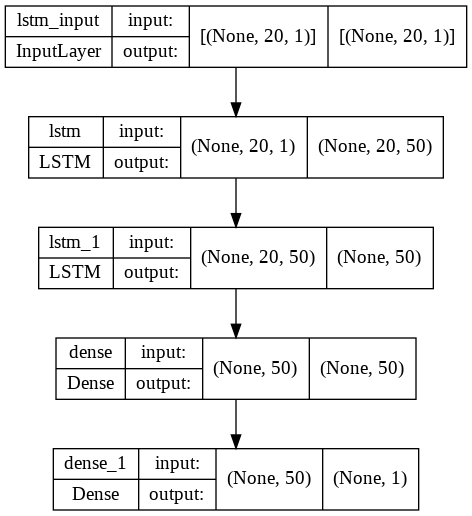

In [22]:
plot_model(model, show_shapes=True, show_layer_names=True )

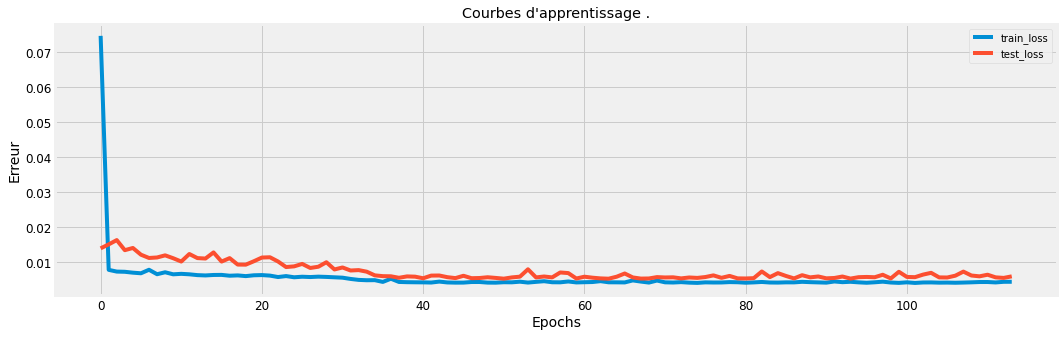

In [23]:
# plot history
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.gca().set(title='Courbes d\'apprentissage .', xlabel='Epochs', ylabel='Erreur')
plt.legend()

In [24]:
import time

for i in range(0, X_test.shape[0]):
    demand_summary = []
    X_input = X_test[i,:,:]
    X_input = np.reshape(X_input, (1, X_input.shape[0], 1))
    X_input = model.predict(X_input)
    forecast = scaler.inverse_transform(X_input)
    
    
    y_input = y_test[i,:]
    y_input = np.reshape(y_input, (1,1))
    actual = scaler.inverse_transform(y_input)
    
    demand_summary.append(actual)
    demand_summary.extend(forecast)
    
    df_animate = pd.DataFrame(demand_summary)
    df_animate = df_animate.T
    df_animate.to_csv('real time demand.csv', mode='a', header=False, index=False)
    
    print(demand_summary)
    time.sleep(2)

[array([[8.16416667]]), array([24.255882], dtype=float32)]
[array([[24.83125]]), array([20.466625], dtype=float32)]
[array([[22.62166667]]), array([27.45935], dtype=float32)]
[array([[23.61708333]]), array([26.549387], dtype=float32)]
[array([[22.31625]]), array([27.08353], dtype=float32)]
[array([[19.66625]]), array([26.529442], dtype=float32)]
[array([[22.02416667]]), array([25.372725], dtype=float32)]
[array([[17.81791667]]), array([26.519672], dtype=float32)]
[array([[22.25791667]]), array([24.514719], dtype=float32)]
[array([[21.95166667]]), array([26.561724], dtype=float32)]
[array([[18.70875]]), array([26.384438], dtype=float32)]
[array([[12.73375]]), array([24.891058], dtype=float32)]
[array([[14.54]]), array([22.028658], dtype=float32)]
[array([[21.69291667]]), array([22.50201], dtype=float32)]
[array([[13.30291667]]), array([25.487202], dtype=float32)]
[array([[11.11916667]]), array([21.746904], dtype=float32)]
[array([[9.23625]]), array([20.538475], dtype=float32)]
[array([[

KeyboardInterrupt: ignored